# Bayesian Optimization

This notebook shows obtaining optimal hyperparameters for a neural network using Bayesian optimization. This technique is more efficient than a Gridsearch or Manual tuning for cases (like the current one) in which there are no resources to carry out parallel model training. 


https://arxiv.org/pdf/1807.02811.pdf

**NOTE:** This notebook is running on *Google Colab* 

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install --upgrade pandas
# !pip install --upgrade matplotlib==2.1.1
# !pip install scikit-optimize

In [3]:
# !ls "drive/My Drive/Colab Notebooks/data"

# Imports, loads and Train/test split
---

In [4]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
data = pd.read_pickle('../data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

Labels assigned to types 

In [6]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

bias - [1 0 0 0]
click - [0 1 0 0]
fake - [0 0 1 0]
truth - [0 0 0 1]


In [7]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1556
Max len title: 14


In [8]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [9]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

**Tran/valid/test split**

In [10]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [11]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [12]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [13]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

In [14]:
import skopt
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective

from numpy.random import seed
# from tensorflow import set_random_seed

import tensorflow as tf

import os

# Find optimal hyperparameters for CNN 

In [15]:
space  = [Real(1e-3, 0.4, name='lr'),
          Real(1e-3, 0.4, name='momentum'),
          Real(1e-3, 0.4, name='dropout1'),
          Real(1e-3, 0.4, name='dropout2'),
          Integer(5,15, name='filters1Title'),
          Integer(25,60, name='denseTitle'),
          Integer(5,15, name='filtersContent'),
          Integer(25,60, name='denseContent') ]

In [16]:
@use_named_args(space)
def cnn_model(**params):
    
    x_train = train_fit
    y_train2 = np.array(y_train.tolist())

    
    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())
    
    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    #Reproducible
    seed(50)
    #     set_random_seed(50)
    tf.random.set_seed(50)
    k.backend.clear_session()
    
    
    #input_title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_title')(title_input)

    x = k.layers.Conv1D(filters = params['filters1Title'], kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
    x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
    x = k.layers.Flatten()(x)
    x = k.layers.Dense(params['denseTitle'], activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)
    
    #input_content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_content')(content_input)
    x2 = k.layers.Conv1D(filters = params['filtersContent'], kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 6, name='Pool1Content')(x2)
    
    x2 = k.layers.Conv1D(filters = 80, kernel_size = 8, strides = 4, activation='relu', name='Conv2Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 2, name='Pool2Content')(x2)

    x2 = k.layers.Flatten()(x2)
    x2 = k.layers.Dense(params['denseContent'], activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)

    #Merge
    x = k.layers.concatenate([x, x2])

    #Common part
    x = k.layers.Dense(100, activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(50, activation='relu')(x)
    x = k.layers.Dropout(params['dropout2'])(x)
    out = k.layers.Dense(4, activation='softmax')(x)


    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    model.compile(k.optimizers.SGD(lr=params['lr'], momentum=params['momentum']), loss='categorical_crossentropy', metrics=['acc'])
    
    model.summary()
    out = model.fit(x=x_train, y=y_train2, batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.1)], 
                    validation_data=(x_valid, y_valid2))
    #Evaluation
    
    acc = model.evaluate(x=x_test, y=y_test2)
    return -acc[1] #Maximize accuracy

In [17]:
r = skopt.gp_minimize(cnn_model, n_random_starts=3, n_calls=5, dimensions=space)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 14)]         0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      [(None, 1556)]       0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 14, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embed_content (Embedding)       (None, 1556, 300)    15000000    content_input[0][0]              
_______________________________________________________________________________________

740/740 [==============================] - 208s 281ms/step - loss: 0.9039 - acc: 0.7322 - val_loss: 0.5795 - val_acc: 0.7830
Epoch 2/20
740/740 [==============================] - 208s 282ms/step - loss: 0.4967 - acc: 0.8319 - val_loss: 0.5451 - val_acc: 0.8126
Epoch 3/20
1811/1811 [==============================] - 52s 29ms/step - loss: 0.5272 - acc: 0.8335
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 14)]         0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      [(None, 1556)]       0                                            
__________________________________________________________________________________________________
embed_title (Embedding) 

740/740 [==============================] - 205s 277ms/step - loss: 0.7028 - acc: 0.7507 - val_loss: 0.5482 - val_acc: 0.8082
Epoch 2/20
740/740 [==============================] - 205s 277ms/step - loss: 0.5218 - acc: 0.8313 - val_loss: 0.5189 - val_acc: 0.8340
Epoch 3/20
1811/1811 [==============================] - 51s 28ms/step - loss: 0.4906 - acc: 0.8557
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 14)]         0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      [(None, 1556)]       0                                            
__________________________________________________________________________________________________
embed_title (Embedding) 

Podemos aceder a los parámetros con los que se obtiene el mínimo en la función de loss (máximo en nuestro caso)

In [18]:
print("PARAMETERS: {}  RESULT {}".format(r.x, r.fun))

PARAMETERS: [0.4, 0.34376395524693715, 0.22538075274187744, 0.4, 5, 25, 5, 28]  RESULT -0.85670405626297


As we can see, with these parameters an accuracy of 0.81 is obtained in the validation set. 

array([[<AxesSubplot:xlabel="Real(low=0.001, high=0.4, prior='uniform', transform='identity')", ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel="Real(low=0.001, high=0.4, prior='uniform', transform='identity')">,
        <AxesSubplot:xlabel="Real(low=0.001, high=0.4, prior='uniform', transform='identity')", ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel="Real(low=0.001, high=0.4, prior='uniform', transform='identity')">,
        <AxesSubplot:>,
        <AxesSubplot:xlabel="Real(low=0.001, high=0.4, prior='uniform', transform='identity')", ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel="Real(low=0.001, high=0.4, prior='uni

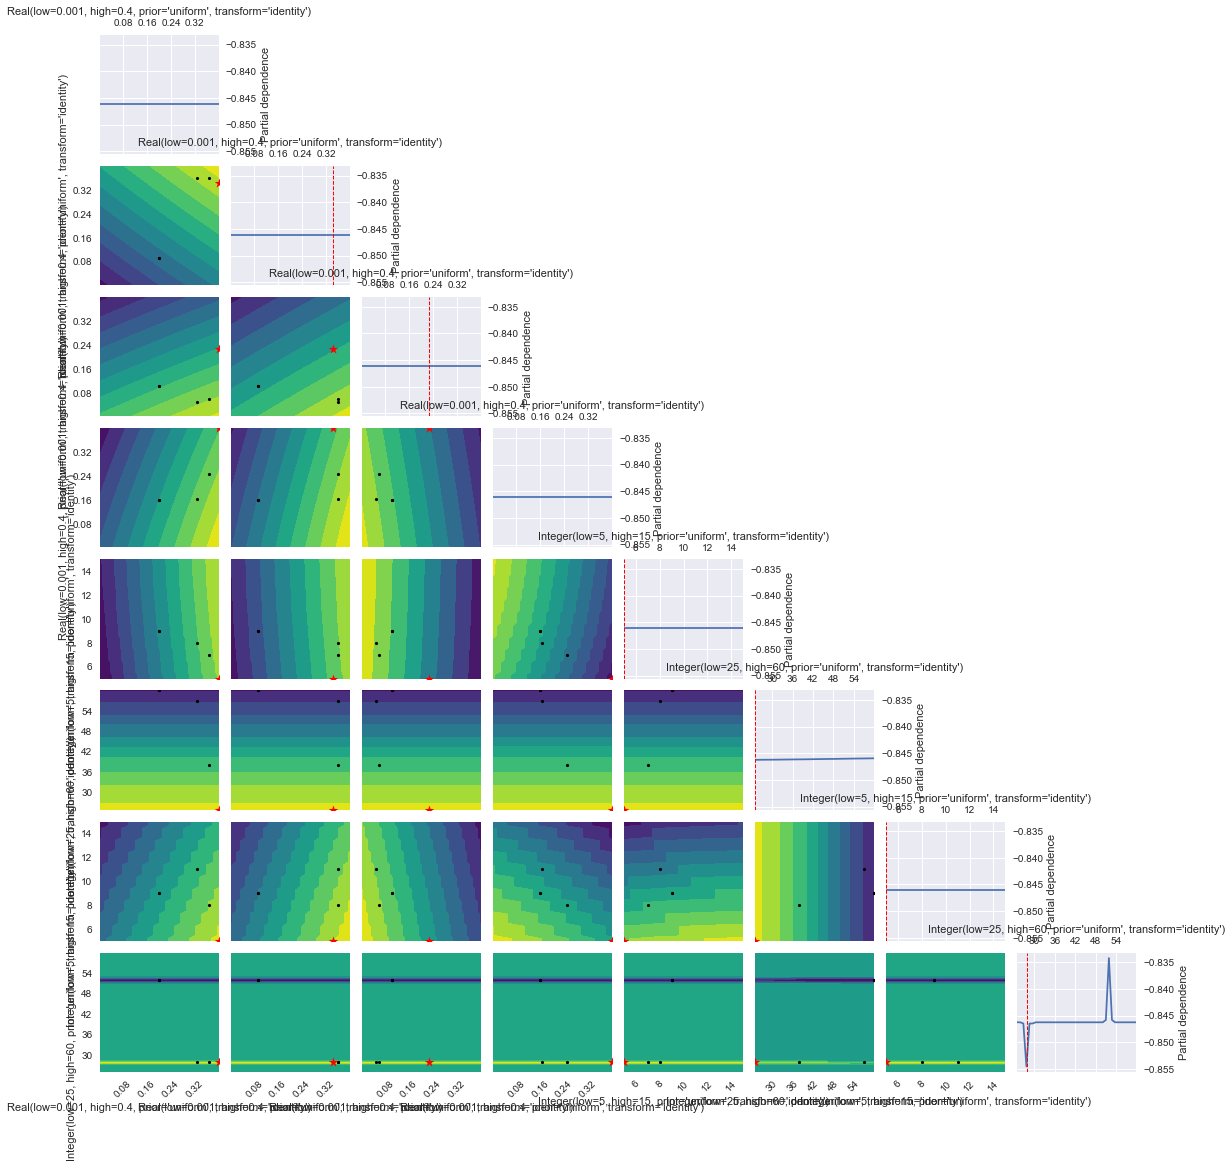

In [19]:
plot_objective(r, dimensions=space)

In [20]:
print("Params")
r.x_iters

Params


[[0.32601861000015364,
  0.3617472072249463,
  0.048075481548376056,
  0.16456059515602914,
  8,
  57,
  11,
  28],
 [0.1983460565696706,
  0.09200515867528518,
  0.10293409557912736,
  0.15913563397938804,
  9,
  60,
  9,
  52],
 [0.1983460565696706,
  0.09200515867528518,
  0.10293409557912736,
  0.15913563397938804,
  9,
  60,
  9,
  52],
 [0.36645507931904503,
  0.35926899494796855,
  0.06011236293675237,
  0.2478326730498372,
  7,
  38,
  8,
  28],
 [0.4, 0.34376395524693715, 0.22538075274187744, 0.4, 5, 25, 5, 28]]

In [21]:
print("Values")
r.func_vals

Values


array([-0.85185504, -0.83354616, -0.83354616, -0.85565144, -0.85670406])